In [7]:
import os
#os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"

import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.quadrature import get_element, Element
from femsolver.operator import Operator
from femsolver.jax_utils import auto_vmap, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

In [8]:
# --- Mesh generation ---
def generate_unit_square_mesh_tri(nx, ny):
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return coords, jnp.array(elements)



# --- Mesh ---
coords, elements = generate_unit_square_mesh_tri(10, 10)
n_nodes = coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x) 
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and 

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$


The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$



In [9]:
class Material(eqx.Module):
    mu: eqx.AbstractVar[float] 
    lmbda: eqx.AbstractVar[float]

In [ ]:

@auto_vmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)

@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2, mu=0, lmbda=0)
def linear_elasticity_energy(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(sigma * eps)



The femsolver provides a generic class `Operator` that can be used to solve FEM problems. This operator is the core of the library as it provide functions that can automatically integrate the energy density function defined above over the range of elements.

Below, we define a class `ElasticityOperator` that inherits from `Operator` and `Material`.


In [11]:
class ElasticityOperator(Operator, Material):
    element: Element
    mu: float
    lmbda: float

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes):
        u_quad, u_grad, detJ = self.element.get_local_values(
            xi, nodal_values, nodes
        )
        value = linear_elasticity_energy(u_grad, self.mu, self.lmbda)
        return wi * value * detJ
    

tri3 = get_element("tri3")
fem = ElasticityOperator(element=tri3, mu=1.0, lmbda=1.0)

Now we prepare the mesh and the boundary conditions and solve the linear elasticity problem.

The total potential energy $\Psi$ is the sum of the elastic strain energy $\Psi_{elastic}$ and the contact penalty energy $\Psi_{contact}$.

$$\Psi(u)=\Psi_{elastic}(u)+\Psi_{contact}(u)$$

The contact energy is defined as:

$$\Psi_{contact}(u)=\frac{1}{2}k_{pen}\int_{\Gamma_c}\langle -g(u)\rangle^2 dA$$


For this example, we define the discrete penalization only at the nodes on the contact surface.
Therefore, the contact energy is defined as:

$$\Psi_{contact}(u)=\frac{1}{2}k_{pen}\sum_{i=1}^{N_c}\langle -g(u_i)\rangle^2 A_{i}$$

where $N_c$ is the number of nodes on the contact surface, $A_i$ is the area of the node $i$, and $g(u_i)$ is the gap function at node $i$.

The gap function is defined as:

$$g(u_i)=x_i+u_i-0.0$$

In [ ]:
def compute_contact_energy(
    u_flat: jnp.ndarray, coords: jnp.ndarray, contact_nodes: jnp.ndarray
) -> jnp.ndarray:
    """
    Compute the contact energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Contact energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_nodes = u[contact_nodes]
    x_nodes = coords[contact_nodes]

    k_pen = 1e2
    node_area_weight = 1.0 # TODO: add the correctarea of the node

    # Loop over nodes on the potential contact surface
    @vmap(in_axes=(0, 0))
    def contact_energy_node(u_node, x_node):
        gap = (x_node[0] + u_node[0]) - 0.0
        penetration = jnp.maximum(-gap, 0.0)
        return 0.5 * k_pen * (penetration**2) * node_area_weight

    return jnp.sum(contact_energy_node(u_nodes, x_nodes))


# --- Total energy ---
def total_energy(
    u_flat: jnp.ndarray,
    coords: jnp.ndarray,
    elements: jnp.ndarray,
    fem: Operator,
    contact_nodes: jnp.ndarray,
) -> jnp.ndarray:
    """
    Compute the total energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        elements: Element indices.
        fem: Operator object.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Total energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_cell = u[elements]
    x_cell = coords[elements]
    elastic_energy = jnp.sum(fem.integrate(u_cell, x_cell))

    # --- Contact energy ---
    contact_energy = compute_contact_energy(u_flat, coords, contact_nodes)

    return elastic_energy + contact_energy

In [ ]:
# define the displacement field
u = jnp.zeros(n_dofs)

# creating functions to compute the gradient and
# Hessian of the total energy using jax
residual = jax.grad(total_energy)
hessian = jax.jacfwd(jax.grad(total_energy))

# --- Apply Dirichlet BCs ---
contact_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(coords[:, 0], 1.0))[0]


fixed_dofs = jnp.concatenate(
    [
        2 * right_nodes,
    ]
)
prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(-0.3)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)


# compute the hessian which is the stiffness matrix
# and the gradient which is the internal force vector
K = hessian(u, coords, elements, fem, contact_nodes)
f_int = residual(u, coords, elements, fem, contact_nodes)


# --- Solve for the displacement ---
# We are using a linear solver here but ideally we would use a Newton solver
# TODO: use Newton solver
f_ext = -f_int - K @ prescribed_values
f_reduced = f_ext[free_dofs]
K_reduced = K[jnp.ix_(free_dofs, free_dofs)]
u_free = jnp.linalg.solve(K_reduced, f_reduced)
u_full = prescribed_values.at[free_dofs].set(u_free)

Now we prepare some functions to compute the stress and to plot the deformed shape with the von-mises stress.

In [16]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


In [17]:
grad_us = fem.gradient(u_full.reshape(-1, n_dofs_per_node)[elements], coords[elements])
strains = compute_strain(grad_us)
stresses = compute_stress(strains, fem.mu, fem.lmbda)
stress_vm = von_mises_stress(stresses)

In [22]:
# --- Visualization ---
from femsolver.plotting import STYLE_PATH

def plot_displacement_and_stress(coords, u, elements, stress, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    plt.figure(figsize=(5, 4))
    plt.triplot(
        coords[:, 0],
        coords[:, 1],
        tri_elements,
        color="black",
        linewidth=0.5,
    )
    plt.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    plt.colorbar(label="Von Mises Stress")
    plt.title("Von Mises Stress on Deformed Mesh")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()


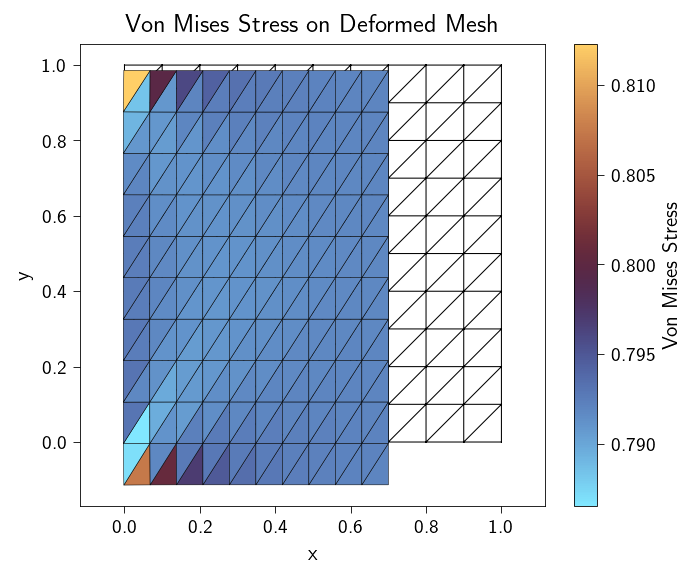

In [23]:
# --- Compute the stress ---    
u = u_full.reshape(-1, n_dofs_per_node)

# --- Plot the displacement and stress ---
plot_displacement_and_stress(coords, u, elements, stress_vm.flatten())